Links to other notebooks in the same folder:
<a href='http://pivotal.io/data-science'><img src='https://raw.githubusercontent.com/crawles/Logos/master/Pivotal_TealOnWhite.png' width='200px' align='right'></a>

<nav class = "navbar navbar-light bg-faded">
    <ul class = "nav navbar-nav">
        <li class = "">
            <a href = "MPP Plotting.ipynb">MPP Plotting</a>
        </li>
        <li class = "">
            <a>MPP Decision Tree</a>
        </li>
        <li class = "">
            <a href = "MPP ROC Curve.ipynb">MPP ROC Curve</a>
        </li>
        

 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20Decision%20Tree.ipynb#Building-a-Decision-Tree-and-Applying-to-Entire-Dataset" data-toc-modified-id="Building-a-Decision-Tree-and-Applying-to-Entire-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building a Decision Tree and Applying to Entire Dataset</a></span></li><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20Decision%20Tree.ipynb#Load-Libraries-and-Set-Default-Settings" data-toc-modified-id="Load-Libraries-and-Set-Default-Settings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Libraries and Set Default Settings</a></span></li><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20Decision%20Tree.ipynb#Connect-to-Database" data-toc-modified-id="Connect-to-Database-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Connect to Database</a></span></li><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20Decision%20Tree.ipynb#Magic-Functions-Useful-for-Interacting-with-the-Cluster" data-toc-modified-id="Magic-Functions-Useful-for-Interacting-with-the-Cluster-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Magic Functions Useful for Interacting with the Cluster</a></span></li></ul></div>

# Building a Decision Tree and Applying to Entire Dataset 

# Load Libraries and Set Default Settings

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import getopt
import os
import sys
import urllib

from IPython.core.display import display, HTML, Image
from IPython.core.magic import register_cell_magic, register_line_cell_magic,\
                               register_line_magic
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import pydot
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, _tree
from sklearn.externals.six import StringIO
from sqlalchemy import create_engine

# Credentials file to connect to database
import credentials
from mpp_plotting import *

In [2]:
# Changes logo to a Pivotal logo
jPrefs = urllib.urlopen("https://raw.githubusercontent.com/crawles/Logos/master/jupyterPrefs.js").read()
HTML('<script>{}</script>'.format(jPrefs))

In [3]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
sns.set_palette('colorblind')
sns.set_style('darkgrid')
blue, green, red, purple, yellow, cyan = sns.color_palette('colorblind')

# Connect to Database

In [4]:
conn = psycopg2.connect(**credentials.login_info_dict)
conn.autocommit = True

# Set the schema name
schema_name = 'template'
psql.execute('SET search_path TO {}'.format(schema_name), conn)

<cursor object at 0x1100efa50; closed: 0>

# Magic Functions Useful for Interacting with the Cluster
These functions allow us to type write and run raw SQL a cell with the magic function at the top.

In [5]:
@register_cell_magic
def readsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), 
    and execute it using the connection object to the backend 
    database. The resulting pandas DataFrame is rendered inline 
    below the cell using IPython.display. You'd use this for SELECT.
    
    Returns a DataFrame with the name specified in the magic
    function. If this is not specified, then the DataFrame
    is called _df. This also takes in an option "-h", followed 
    by a number. This will show only the specified number of rows
    in the DataFrame.
    """
    # Use the global connection object defined above.
    global conn
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist) 
    # If '-h' tag is specified, set the number of rows to display
    if '-h' in optdict:
        head_num = int(optdict['-h'])
    
    # Do string formatting. If a PL/Python function
    # is being created, then it should not try and
    # format whatever is inside the function.
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals()) 
    
    # If there is more than one table name specified,
    # throw an exception.
    if len(args) > 1:
        raise Exception('More than one table name specified.')

    elif len(args) == 1:
        # If a table name is specified, store it as that
        table_name = args[0]
        globals()[table_name] = psql.read_sql(cell, conn)
        if '-h' in optdict:
            # If head_num is not 0, then display rows
            if head_num != 0:
                display(globals()[table_name].head(int(optdict['-h'])))
        else:
            display(globals()[table_name])

    else:
        # Otherwise, call it _df
        global _df
        _df = psql.read_sql(cell, conn)
        if '-h' in optdict:
            # If head_num is not 0, then display rows
            if head_num != 0:
                display(_df.head(head_num))
        else:
            display(_df)

@register_cell_magic
def execsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL),
    and execute it using the connection object to the backend 
    database. You'd use this for CREATE/UPDATE/DELETE.
    """
    # Use the global connection object defined above.
    global conn
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist)
    
    # Do string formatting. If a PL/Python function
    # is being created, then it should not try and
    # format whatever is inside the function.
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals())
    psql.execute(cell, conn)

@register_cell_magic
def printsql(line, cell):
    """
    Show the SQL query that will be run.
    """
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist)
    
    # Do string formatting. If a PL/Python function
    # is being created, then it should not try and
    # format whatever is inside the function.
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals())
    print cell

# We delete these to avoid name conflicts for automagic to work
del execsql, readsql, printsql

In [6]:
print '{user}'.format(**credentials.login_info_dict)

postgres


In [7]:
engine = create_engine('postgresql://{user}:{password}@{host}:5432/{database}'.format(**credentials.login_info_dict))
titanic = sns.load_dataset('titanic')
titanic.to_sql('titanic', engine, schema = 'template', if_exists='replace', index = False)

In [8]:
%%readsql -h 10 titanicdf
SELECT *
FROM titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,None,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,None,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,None,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,None,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,None,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,None,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,None,Cherbourg,yes,False


In [9]:
dep_var = ['survived']

# cleansing 
numerics = ['float64','int64']
titanicdf_clean = titanicdf.select_dtypes(include=numerics).dropna()

# build X,y
X = titanicdf_clean.drop(dep_var, axis=1)
y = titanicdf_clean[dep_var]

# features, label names
features = X.columns
labels = ['died', 'survived']

# split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.1, random_state = 33)

# train/test model
cl = DecisionTreeClassifier(max_depth=4)
cl.fit(Xtrain,ytrain)
cl.score(Xtest,ytest)

0.72222222222222221

AUC: 0.736882716049


/Users/gtam/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


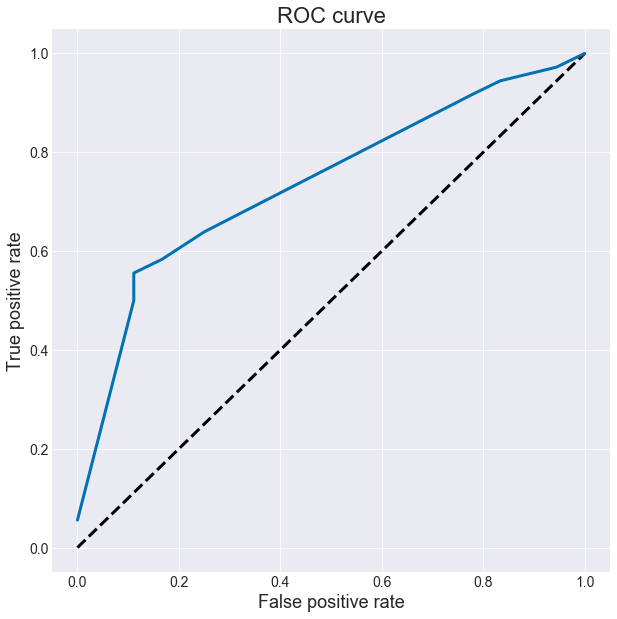

In [10]:
ypred = cl.predict(Xtest)
ypred_prob = cl.predict_proba(Xtest)[:,1]
auc = roc_auc_score(ytest, ypred_prob)
print "AUC: {}".format(auc)

def plot_roc(ytest, ypred_prob):
    fpr, tpr, _ = roc_curve(ytest, ypred_prob)
    plt.figure(1,figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
plot_roc(ytest, ypred_prob)

In [11]:
def tree_to_code(tree, feature_names):
    ''' Returns SQL conditional statements to generate leafs 
        Modified from http://stackoverflow.com/a/39772170'''
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    cur_leafid = [0]
    leaves = []
    
    def recurse(node, depth, parent = ''):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # left side of tree
            curr_cond =  '{} <= {} AND '.format(name,threshold)
            if depth == tree_.max_depth:
                cur_leafid[0] += 1
                l = "({} {} <= {})".format(parent, name, threshold) + ' AS leaf_{}'.format(cur_leafid[0])
                leaves.append(l)
            recurse(tree_.children_left[node], depth + 1, parent + curr_cond)
            
            # right side of tree
            curr_cond =  '{} > {} AND '.format(name,threshold)
            if depth == tree_.max_depth:
                cur_leafid[0] += 1
                l = "({} {} > {})".format(parent, name, threshold) + ' AS leaf_{}'.format(cur_leafid[0])
                leaves.append(l)
            recurse(tree_.children_right[node], depth + 1, parent + curr_cond)

    recurse(0, 1)
    return leaves

leaves = tree_to_code(cl,features)
leaves_str = ',\n'.join(leaves)
num_leaves = len(leaves)
group_by = tuple(range(1,num_leaves+1))

In [12]:
%%readsql dfresults
SELECT {leaves_str}, count(*) 
FROM titanic 
GROUP BY {group_by};

,leaf_1,leaf_2,leaf_3,leaf_4,leaf_5,leaf_6,leaf_7,leaf_8,leaf_9,leaf_10,count
0,False,False,False,False,True,False,False,False,False,False,58
1,False,False,False,False,False,False,True,False,False,False,266
2,False,True,False,False,False,False,False,False,False,False,50
3,False,False,False,False,False,False,None,False,False,False,4
4,False,False,False,False,False,False,False,True,False,False,4
5,False,False,False,False,False,False,False,False,True,False,33
6,False,False,False,False,False,False,None,False,False,None,50
7,False,False,False,False,False,False,False,False,False,True,48
8,False,False,None,None,None,False,False,False,False,False,23
9,False,False,False,False,False,False,False,False,False,False,13


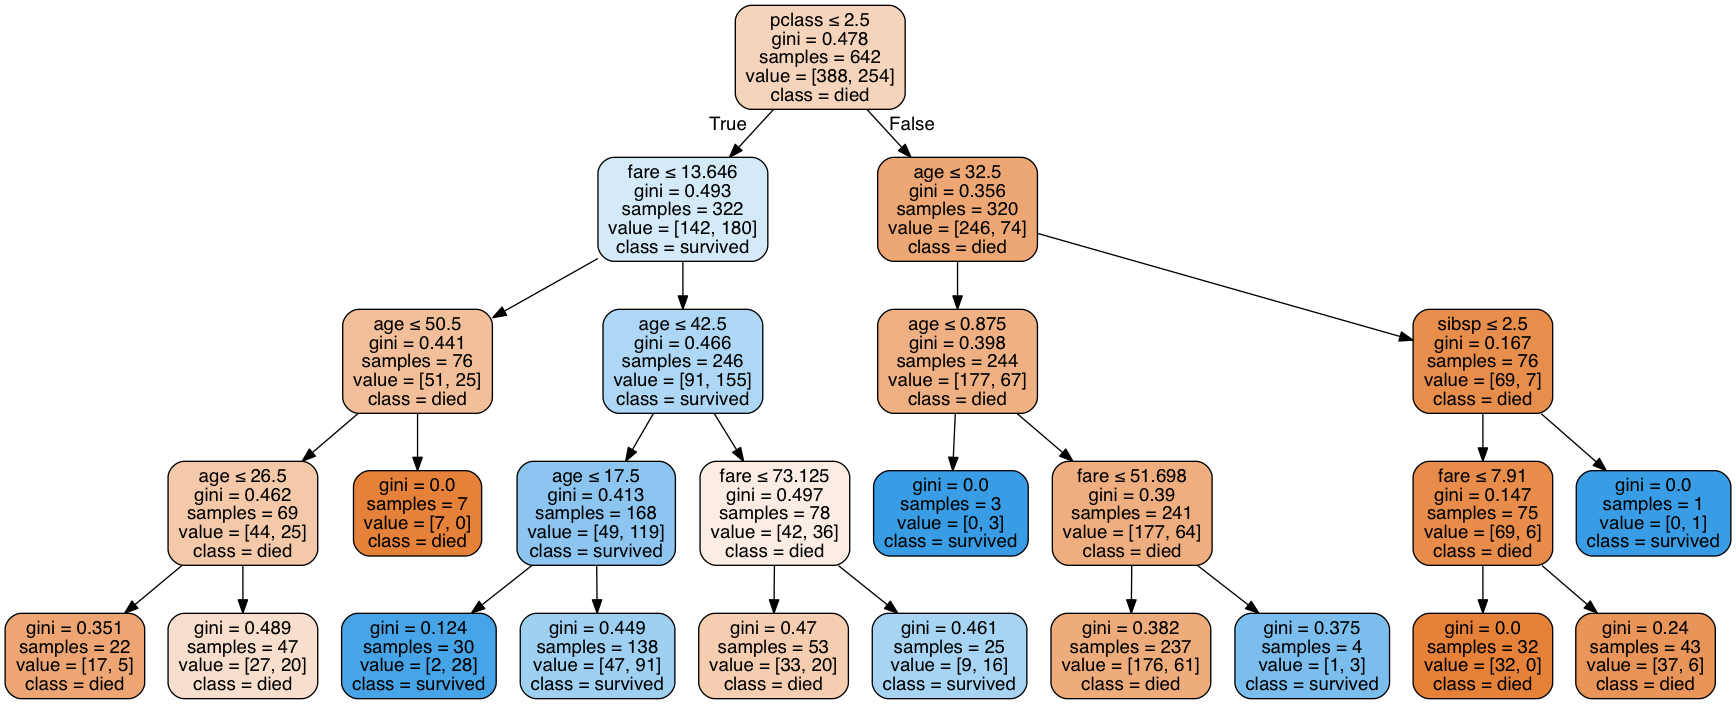

In [13]:
# plot decision tree on training data
dot_data = StringIO()  
export_graphviz(cl, out_file=dot_data,  
                    feature_names=features,
                    class_names=labels,  
                    filled=True, rounded=True,  
                    special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png())  